In [2]:
import numpy as np
%load_ext autoreload
%autoreload 2
import pandas as pd
from helpers.training import *
from helpers.visualizations import *
from helpers.preprocessing import *
from helpers.aequitas_methods import *
from helpers.mitigation_methods import *
from aequitas.flow.methods.inprocessing import FairlearnClassifier
from sklearn.metrics import classification_report
from IPython.display import display, HTML
from aequitas import Audit
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import openml
import warnings
import math
warnings.filterwarnings(action='ignore')

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[inFairness]'


In [3]:
ml_ds = openml.datasets.get_dataset(43141)
df, * _ = ml_ds.get_data()
print(ml_ds.description[:500])

def categorize_target(target):
    if target<median:
        return 0
    if target >=median:
        return 1
def categorize_age(age):
    if age<30:
        return '0'
    if (age >=30) and (age<50):
        return '1'
    if age>=50:
        return '2'

df.rename(columns={'MAR': 'marital status', 'RAC1P':'race', 'AGEP':'age', 'PINCP':'target'}, inplace=True)
target = "target"
median = df[target].median()
df[target] = df[target].apply(categorize_target)
df["age"] = df["age"].apply(categorize_age)
df['race'] = np.where(df['race']==1,1,2)
protected_attributes = ["age","race","marital status"]

The ACSIncome dataset is one of five datasets created by Ding et al. as an improved alternative to the popular UCI Adult dataset. The authors compiled data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS). Data is provided for all 50 states and Puerto Rico. This upload represents the raw data from only 2018. The data contains 1,664,500 rows, 10 features, and 1 target variable. An additional column for the state code is provided for convenience.  All columns are describ


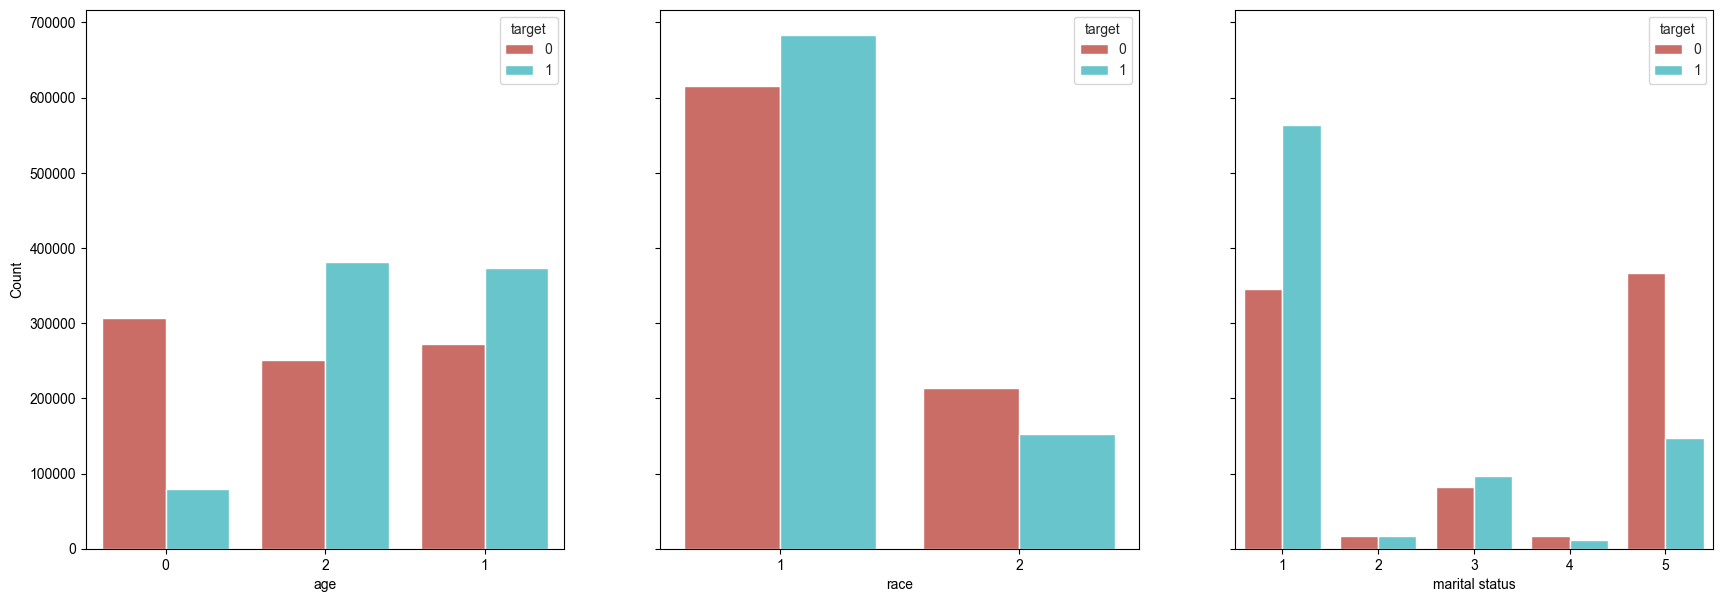

In [4]:
def plot_attributes(dataset,attributes):
    fontsize = 10
    num_elements = len(attributes)
    num_cols = min(4, num_elements)  
    num_rows = math.ceil(num_elements / num_cols)
    
    fig_width = 7 * num_cols
    fig_height = 7 * num_rows
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), sharey=True, gridspec_kw={'hspace':0.5})
    ax = ax.flatten()
    plt.subplots_adjust(hspace = 1.5)
    sns.set_style("whitegrid")
    for i, attribute in enumerate(attributes):
        g0 = sns.countplot(x=attribute, data=dataset, palette="hls", 
                      ax=ax[i],hue=target) # order=dataset[attribute].value_counts().index)
        g0.set_xlabel(attribute, fontsize=fontsize)
        g0.set_ylabel("Count", fontsize=fontsize)
plot_attributes(df,protected_attributes)

In [5]:
# normalize data, convert to numerical
categorical_attributes = get_categorical_attributes(df)
df_num = df.copy()
encode_categorical_attributes(df_num, categorical_attributes)
scaler = MinMaxScaler()

for col in df_num.columns:
    if col not in categorical_attributes and col != target:
        df_num[col] = scaler.fit_transform(df_num[[col]])

df['marital status'] = df['marital status'].astype(int)

['age']
Attribute: age
{'0': 0, '1': 1, '2': 2}


In [6]:
'''
Top 3 protected attributes: Race, MaritalStatus, Age. Create new dataset with new columns containing the intersection of these attributes. Convert them to numerical.
'''
df_intersect = df.copy()
df_intersect["race/maritalstatus"] = df_intersect["race"].astype(str) + " " +  df_intersect["marital status"].astype(str)
df_intersect["race/age"] = df_intersect["race"].astype(str) + " " + df_intersect["age"].astype(str)
df_intersect["maritalstatus/age"] = df_intersect["marital status"].astype(str) + " " + df_intersect["age"].astype(str)

df_intersect.drop(["race", "marital status", "age"], axis=1, inplace=True)

categorical_attributes = get_categorical_attributes(df_intersect)
df_num_int = df_intersect.copy()
encode_categorical_attributes(df_num_int, categorical_attributes)
scaler = MinMaxScaler()

for col in df_num_int.columns:
    if col not in categorical_attributes and col != target:
        df_num_int[col] = scaler.fit_transform(df_num_int[[col]])
protected_attributes_int = ["race/maritalstatus","race/age","maritalstatus/age"]

['race/maritalstatus', 'race/age', 'maritalstatus/age']
Attribute: race/maritalstatus
{'1 1': 0, '1 2': 1, '1 3': 2, '1 4': 3, '1 5': 4, '2 1': 5, '2 2': 6, '2 3': 7, '2 4': 8, '2 5': 9}
Attribute: race/age
{'1 0': 0, '1 1': 1, '1 2': 2, '2 0': 3, '2 1': 4, '2 2': 5}
Attribute: maritalstatus/age
{'1 0': 0, '1 1': 1, '1 2': 2, '2 0': 3, '2 1': 4, '2 2': 5, '3 0': 6, '3 1': 7, '3 2': 8, '4 0': 9, '4 1': 10, '4 2': 11, '5 0': 12, '5 1': 13, '5 2': 14}


In [7]:
def split_and_train(data, attributes):
    y = data.loc[:, target]
    x = data.drop(target, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
    models = {"Catboost",
                  "LogisticRegression",
                  "RandomForest",
                  "DecisionTree"
                  }
    y_predicted_dict = {}
    metrics_dict = {}
    for m in models:
            model = choose_model(m, x_train, y_train)
            y_predicted =  evaluate_model(model, x_train, x_test, y_train, y_test)
            attribute_metrics  = calc_metrics(x_test=x_test,y_test=y_test,y_predicted=y_predicted,attributes=attributes, target=target)
            metrics_dict[m] = attribute_metrics
            y_predicted_dict[m] = y_predicted
            print(f"Classification report for model: {model} : \n {classification_report(y_test, y_predicted)}")
            # plot_roc_curve(y_true=y_test, y_pred=y_predicted, model_name=m)
    return x_test, y_test, y_predicted_dict, metrics_dict

def plot_audit(dataset, attributes):
    audit = Audit(dataset[['score','label_value']+attributes])
    summary = audit.summary_plot(["tpr","fpr","fnr","tnr","pprev"])
    summary.show()

In [8]:
"""
Train and calculate fairness metrics for original dataset.
"""
x_test, y_test, y_predicted_dict, metrics_dict = split_and_train(df,protected_attributes)
df_test = calc_fairness_report(x_test, y_test, y_predicted_dict['Catboost'], target, protected_attributes)

---------- Model name:  DecisionTree ----------

Accuracy score training:
0.7674
Accuracy score test:
0.7664
----------------------------------------

Privileged groups:  [{'age': '1'}]
Unprivileged groups:  [{'age': '0'}, {'age': '2'}]
Disparate Impact Ratio for age: nan
Statistical Parity Difference for age: nan


Privileged groups:  [{'race': 1}]
Unprivileged groups:  [{'race': 2}]
Disparate Impact Ratio for race: 0.827
Statistical Parity Difference for race: -0.097


Privileged groups:  [{'marital status': 1}]
Unprivileged groups:  [{'marital status': 4}, {'marital status': 2}, {'marital status': 3}, {'marital status': 5}]
Disparate Impact Ratio for marital status: 0.523
Statistical Parity Difference for marital status: -0.328


Classification report for model: DecisionTreeClassifier(max_depth=5, min_samples_leaf=40, min_samples_split=4) : 
               precision    recall  f1-score   support

           0       0.79      0.73      0.76    166114
           1       0.75      0.80

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,age,0,0.86,0.56,0.94,0.11,0.30,0.06,0.44,0.89,0.70,0.07,0.17,0.21
1,age,1,0.79,0.85,0.70,0.22,0.20,0.30,0.15,0.78,0.80,0.46,0.62,0.58
2,age,2,0.77,0.84,0.65,0.27,0.22,0.35,0.16,0.73,0.78,0.47,0.64,0.60
3,race,1,0.80,0.84,0.76,0.19,0.21,0.24,0.16,0.81,0.79,0.83,0.56,0.53
4,race,2,0.79,0.74,0.83,0.18,0.25,0.17,0.26,0.82,0.75,0.17,0.41,0.41
5,marital status,1,0.79,0.87,0.65,0.24,0.20,0.35,0.13,0.76,0.80,0.70,0.67,0.62
6,marital status,2,0.72,0.67,0.77,0.30,0.26,0.23,0.33,0.70,0.74,0.02,0.44,0.49
7,marital status,3,0.75,0.79,0.70,0.26,0.25,0.30,0.21,0.74,0.75,0.12,0.57,0.54
8,marital status,4,0.78,0.68,0.84,0.20,0.27,0.16,0.32,0.80,0.73,0.01,0.36,0.39
9,marital status,5,0.84,0.66,0.91,0.13,0.26,0.09,0.34,0.87,0.74,0.15,0.25,0.29


Majority class for:  age  is: 1
Majority class for:  race  is: 1
Majority class for:  marital status  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,age,0,1.47,3.02,0.50,0.21,1.14,0.16,0.27,0.88,...,True,True,True,True,True,True,True,True,True,True
1,age,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,age,2,1.07,1.10,1.22,1.18,0.94,1.02,1.04,0.98,...,True,True,True,True,True,True,True,True,True,True
3,race,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
4,race,2,1.18,1.57,0.92,0.70,1.02,0.21,0.73,0.95,...,True,True,True,True,True,True,True,True,True,True
5,marital status,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
6,marital status,2,1.30,2.63,1.23,0.65,0.93,0.02,0.66,0.93,...,True,True,True,True,True,True,True,True,True,True
7,marital status,3,1.25,1.63,1.06,0.87,0.98,0.17,0.84,0.94,...,True,True,True,True,True,True,True,True,True,True
8,marital status,4,1.35,2.55,0.82,0.46,1.06,0.02,0.54,0.91,...,True,True,True,True,True,True,True,True,True,True
9,marital status,5,1.31,2.72,0.55,0.26,1.14,0.21,0.38,0.92,...,True,True,True,True,True,True,True,True,True,True


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,age,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False
1,0,binary 0/1,marital status,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False
2,0,binary 0/1,race,False,False,True,False,True,False,True,True,True,True,False,False,False,False,False


In [37]:
"""
Train and calculate fariness metrics for the dataset obtained by the intersection of protected attributes.
"""
x_test_int, y_test_int, y_predicted_dict_int, metrics_dict_int = split_and_train(df_num_int,protected_attributes_int)
df_test_int = calc_fairness_report(x_test_int, y_test_int, y_predicted_dict_int['Catboost'], target, protected_attributes_int)


---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.7662
Accuracy score test:
0.7642
----------------------------------------

Privileged groups:  [{'race/maritalstatus': 0}]
Unprivileged groups:  [{'race/maritalstatus': 6}, {'race/maritalstatus': 8}, {'race/maritalstatus': 3}, {'race/maritalstatus': 1}, {'race/maritalstatus': 7}, {'race/maritalstatus': 2}, {'race/maritalstatus': 9}, {'race/maritalstatus': 4}, {'race/maritalstatus': 5}]
Disparate Impact Ratio for race/maritalstatus: 0.500
Statistical Parity Difference for race/maritalstatus: -0.358


Privileged groups:  [{'race/age': 2}]
Unprivileged groups:  [{'race/age': 3}, {'race/age': 5}, {'race/age': 4}, {'race/age': 1}, {'race/age': 0}]
Disparate Impact Ratio for race/age: 0.605
Statistical Parity Difference for race/age: -0.280


Privileged groups:  [{'maritalstatus/age': 2}]
Unprivileged groups:  [{'maritalstatus/age': 3}, {'maritalstatus/age': 9}, {'maritalstatus/age': 4}, {'maritalstatus/age': 6

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race/maritalstatus,0,0.79,0.89,0.63,0.24,0.19,0.37,0.11,0.76,0.81,0.60,0.70,0.64
1,race/maritalstatus,1,0.71,0.67,0.76,0.32,0.25,0.24,0.33,0.68,0.75,0.01,0.47,0.52
2,race/maritalstatus,2,0.75,0.82,0.67,0.25,0.25,0.33,0.18,0.75,0.75,0.10,0.60,0.55
3,race/maritalstatus,3,0.78,0.72,0.83,0.19,0.25,0.17,0.28,0.81,0.75,0.01,0.40,0.41
4,race/maritalstatus,4,0.83,0.67,0.90,0.13,0.25,0.10,0.33,0.87,0.75,0.11,0.27,0.30
5,race/maritalstatus,5,0.77,0.81,0.72,0.24,0.22,0.28,0.19,0.76,0.78,0.11,0.57,0.54
6,race/maritalstatus,6,0.73,0.59,0.83,0.25,0.30,0.17,0.41,0.75,0.70,0.00,0.33,0.40
7,race/maritalstatus,7,0.74,0.71,0.76,0.26,0.27,0.24,0.29,0.74,0.73,0.02,0.46,0.47
8,race/maritalstatus,8,0.76,0.52,0.88,0.22,0.30,0.12,0.48,0.78,0.70,0.00,0.26,0.35
9,race/maritalstatus,9,0.83,0.58,0.92,0.14,0.28,0.08,0.42,0.86,0.72,0.04,0.21,0.26


Majority class for:  race/maritalstatus  is: 0
Majority class for:  race/age  is: 2
Majority class for:  maritalstatus/age  is: 2
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,race/maritalstatus,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,True,True,True,True,True
1,race/maritalstatus,1,1.28,2.84,1.31,0.65,0.90,0.02,0.67,0.93,...,True,True,True,True,True,True,True,True,True,True
2,race/maritalstatus,2,1.27,1.61,1.04,0.88,0.99,0.17,0.86,0.93,...,False,False,False,False,False,False,False,False,False,False
3,race/maritalstatus,3,1.30,2.46,0.80,0.46,1.06,0.01,0.57,0.93,...,False,False,False,False,False,True,True,False,False,False
4,race/maritalstatus,4,1.30,2.86,0.55,0.26,1.14,0.19,0.38,0.93,...,True,True,True,True,True,True,True,True,True,True
5,race/maritalstatus,5,1.15,1.64,0.97,0.74,1.01,0.18,0.81,0.96,...,True,True,True,True,True,True,True,True,True,True
6,race/maritalstatus,6,1.55,3.61,1.02,0.45,0.99,0.00,0.48,0.87,...,True,True,True,True,True,True,True,True,True,True
7,race/maritalstatus,7,1.40,2.52,1.05,0.64,0.98,0.03,0.66,0.90,...,True,True,True,True,True,True,True,True,True,True
8,race/maritalstatus,8,1.53,4.15,0.91,0.31,1.03,0.00,0.37,0.87,...,True,True,True,True,True,True,True,True,True,True
9,race/maritalstatus,9,1.42,3.67,0.56,0.21,1.14,0.06,0.30,0.90,...,True,True,True,True,True,True,True,True,True,True


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,maritalstatus/age,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,0,binary 0/1,race/age,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,0,binary 0/1,race/maritalstatus,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False


# Apply pre-processing bias mitigation methods

In [16]:
'''
1: Massaging method (Flips selected labels to reduce prevalence disparity between groups), train and calculate metrics.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_m1 = pre_process_massaging(data_to_transform, "race/maritalstatus",target)
data_transformed_m1["race/maritalstatus"] = data_transformed_m1["race/maritalstatus"].astype(int)
data_transformed_m2 = pre_process_massaging(data_transformed_m1, "race/age",target)
data_transformed_m2["race/age"] = data_transformed_m2["race/age"].astype(int)
data_transformed_m3= pre_process_massaging(data_transformed_m2, "maritalstatus/age",target)
data_transformed_m3["maritalstatus/age"] = data_transformed_m3["maritalstatus/age"].astype(int)

#train on the transformed dataset
x_test_ms, y_test_ms, y_predicted_dict_transformed, metrics_ms_dict = split_and_train(data_transformed_m3,protected_attributes_int)
#calculate the fairness report
df_test_transformed =calc_fairness_report(x_test_ms, y_test_ms, y_predicted_dict_transformed["Catboost"],target,protected_attributes_int)

---------- Model name:  DecisionTree ----------

Accuracy score training:
0.8646
Accuracy score test:
0.8635
----------------------------------------

Privileged groups:  [{'race/maritalstatus': 0}]
Unprivileged groups:  [{'race/maritalstatus': 6}, {'race/maritalstatus': 8}, {'race/maritalstatus': 3}, {'race/maritalstatus': 1}, {'race/maritalstatus': 7}, {'race/maritalstatus': 2}, {'race/maritalstatus': 9}, {'race/maritalstatus': 4}, {'race/maritalstatus': 5}]
Disparate Impact Ratio for race/maritalstatus: 0.688
Statistical Parity Difference for race/maritalstatus: -0.196


Privileged groups:  [{'race/age': 2}]
Unprivileged groups:  [{'race/age': 3}, {'race/age': 5}, {'race/age': 4}, {'race/age': 1}, {'race/age': 0}]
Disparate Impact Ratio for race/age: 0.961
Statistical Parity Difference for race/age: -0.021


Privileged groups:  [{'maritalstatus/age': 2}]
Unprivileged groups:  [{'maritalstatus/age': 3}, {'maritalstatus/age': 9}, {'maritalstatus/age': 4}, {'maritalstatus/age': 6}, {'m

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race/maritalstatus,0,0.92,0.96,0.86,0.06,0.09,0.14,0.04,0.94,0.91,0.55,0.64,0.61
1,race/maritalstatus,1,0.87,0.83,0.89,0.08,0.24,0.11,0.17,0.92,0.76,0.01,0.33,0.30
2,race/maritalstatus,2,0.87,0.92,0.85,0.05,0.22,0.15,0.08,0.95,0.78,0.07,0.43,0.37
3,race/maritalstatus,3,0.86,0.86,0.87,0.07,0.24,0.13,0.14,0.93,0.76,0.01,0.37,0.33
4,race/maritalstatus,4,0.95,0.93,0.96,0.07,0.04,0.04,0.07,0.93,0.96,0.21,0.50,0.51
5,race/maritalstatus,5,0.95,0.92,0.96,0.04,0.07,0.04,0.08,0.96,0.93,0.07,0.34,0.34
6,race/maritalstatus,6,0.72,0.67,0.77,0.27,0.29,0.23,0.33,0.73,0.71,0.00,0.44,0.46
7,race/maritalstatus,7,0.85,0.82,0.94,0.35,0.03,0.06,0.18,0.65,0.97,0.02,0.62,0.74
8,race/maritalstatus,8,0.76,0.76,0.77,0.21,0.27,0.23,0.24,0.79,0.73,0.01,0.47,0.45
9,race/maritalstatus,9,0.86,0.74,0.90,0.09,0.28,0.10,0.26,0.91,0.72,0.04,0.26,0.25


Majority class for:  race/maritalstatus  is: 0
Majority class for:  race/age  is: 2
Majority class for:  maritalstatus/age  is: 2
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,race/maritalstatus,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,True,True,True,True,True
1,race/maritalstatus,1,2.74,4.76,1.27,0.79,0.98,0.02,0.52,0.83,...,True,True,True,True,True,True,True,True,True,True
2,race/maritalstatus,2,2.52,2.35,0.88,1.04,1.01,0.13,0.67,0.85,...,False,False,False,False,False,False,False,False,False,False
3,race/maritalstatus,3,2.71,3.94,1.21,0.91,0.99,0.02,0.58,0.84,...,False,True,True,False,True,True,True,False,False,True
4,race/maritalstatus,4,0.48,1.81,1.08,0.30,0.99,0.38,0.77,1.05,...,True,True,True,True,True,True,True,True,True,True
5,race/maritalstatus,5,0.82,2.14,0.64,0.26,1.02,0.12,0.53,1.02,...,True,True,True,True,True,True,True,True,True,True
6,race/maritalstatus,6,3.27,9.14,4.41,1.62,0.78,0.01,0.68,0.78,...,False,True,True,False,True,True,True,False,False,True
7,race/maritalstatus,7,0.31,5.06,5.72,0.44,0.69,0.04,0.96,1.07,...,True,True,True,True,True,True,True,True,True,True
8,race/maritalstatus,8,3.04,6.74,3.38,1.59,0.84,0.01,0.73,0.80,...,True,True,True,True,True,True,True,True,True,True
9,race/maritalstatus,9,3.20,7.12,1.41,0.67,0.97,0.08,0.40,0.79,...,True,True,True,True,True,True,True,True,True,True


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,maritalstatus/age,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False
1,0,binary 0/1,race/age,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False
2,0,binary 0/1,race/maritalstatus,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [17]:
# compare disparities to the original dataset
plot_audit(df_test, protected_attributes)
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed, protected_attributes_int)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [236]:
''' 
2: Prevalance Sampling: Generates a training sample with controllable balanced prevalence for the groups in dataset, either by undersampling or oversampling.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_ps1 = pre_process_prev_sampling(data_to_transform, "race/maritalstatus",target)
data_transformed_ps1["race/maritalstatus"] = data_transformed_ps1["race/maritalstatus"].astype(int)
data_transformed_ps2 = pre_process_prev_sampling(data_transformed_ps1, "race/age",target)
data_transformed_ps2["race/age"] = data_transformed_ps2["race/age"].astype(int)
data_transformed_ps3= pre_process_prev_sampling(data_transformed_ps2, "maritalstatus/age",target)
data_transformed_ps3["maritalstatus/age"] = data_transformed_ps3["maritalstatus/age"].astype(int)

#train the new dataset
x_test_ps, y_test_ps, y_predicted_dict_ps, metrics_ps_dict = split_and_train(data_transformed_ps3,protected_attributes_int)
df_test_transformed_ps =calc_fairness_report(x_test_ps, y_test_ps, y_predicted_dict_ps["Catboost"],target,protected_attributes_int)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_ps, protected_attributes_int)

[INFO] 2024-09-02 10:59:16 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-09-02 10:59:16 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-09-02 10:59:16 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-09-02 10:59:16 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-09-02 10:59:16 methods.preprocessing.PrevalenceSampling - Original group 9 size: 148431


INFO:methods.preprocessing.PrevalenceSampling:Original group 9 size: 148431


[INFO] 2024-09-02 10:59:16 methods.preprocessing.PrevalenceSampling - Final group 9 size: 76368


INFO:methods.preprocessing.PrevalenceSampling:Final group 9 size: 76368


[INFO] 2024-09-02 10:59:16 methods.preprocessing.PrevalenceSampling - Original group 4 size: 365520


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 365520


[INFO] 2024-09-02 10:59:17 methods.preprocessing.PrevalenceSampling - Final group 4 size: 216079


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 216079


[INFO] 2024-09-02 10:59:17 methods.preprocessing.PrevalenceSampling - Original group 8 size: 9458


INFO:methods.preprocessing.PrevalenceSampling:Original group 8 size: 9458


[INFO] 2024-09-02 10:59:17 methods.preprocessing.PrevalenceSampling - Final group 8 size: 6494


INFO:methods.preprocessing.PrevalenceSampling:Final group 8 size: 6494


[INFO] 2024-09-02 10:59:17 methods.preprocessing.PrevalenceSampling - Original group 2 size: 144540


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 144540


[INFO] 2024-09-02 10:59:17 methods.preprocessing.PrevalenceSampling - Final group 2 size: 129078


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 129078


[INFO] 2024-09-02 10:59:18 methods.preprocessing.PrevalenceSampling - Original group 3 size: 18994


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 18994


[INFO] 2024-09-02 10:59:18 methods.preprocessing.PrevalenceSampling - Final group 3 size: 15742


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 15742


[INFO] 2024-09-02 10:59:18 methods.preprocessing.PrevalenceSampling - Original group 0 size: 741461


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 741461


[INFO] 2024-09-02 10:59:18 methods.preprocessing.PrevalenceSampling - Final group 0 size: 540864


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 540864


[INFO] 2024-09-02 10:59:18 methods.preprocessing.PrevalenceSampling - Original group 1 size: 27611


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 27611


[INFO] 2024-09-02 10:59:19 methods.preprocessing.PrevalenceSampling - Final group 1 size: 26363


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 26363


[INFO] 2024-09-02 10:59:19 methods.preprocessing.PrevalenceSampling - Original group 5 size: 167243


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 167243


[INFO] 2024-09-02 10:59:19 methods.preprocessing.PrevalenceSampling - Final group 5 size: 151936


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 151936


[INFO] 2024-09-02 10:59:19 methods.preprocessing.PrevalenceSampling - Original group 7 size: 34271


INFO:methods.preprocessing.PrevalenceSampling:Original group 7 size: 34271


[INFO] 2024-09-02 10:59:19 methods.preprocessing.PrevalenceSampling - Final group 7 size: 32145


INFO:methods.preprocessing.PrevalenceSampling:Final group 7 size: 32145


[INFO] 2024-09-02 10:59:19 methods.preprocessing.PrevalenceSampling - Original group 6 size: 6971


INFO:methods.preprocessing.PrevalenceSampling:Original group 6 size: 6971


[INFO] 2024-09-02 10:59:19 methods.preprocessing.PrevalenceSampling - Final group 6 size: 5627


INFO:methods.preprocessing.PrevalenceSampling:Final group 6 size: 5627


[INFO] 2024-09-02 10:59:19 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-09-02 10:59:20 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-09-02 10:59:20 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-09-02 10:59:20 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-09-02 10:59:20 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-09-02 10:59:20 methods.preprocessing.PrevalenceSampling - Original group 0 size: 167844


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 167844


[INFO] 2024-09-02 10:59:20 methods.preprocessing.PrevalenceSampling - Final group 0 size: 104755


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 104755


[INFO] 2024-09-02 10:59:20 methods.preprocessing.PrevalenceSampling - Original group 4 size: 126227


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 126227


[INFO] 2024-09-02 10:59:20 methods.preprocessing.PrevalenceSampling - Final group 4 size: 112628


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 112628


[INFO] 2024-09-02 10:59:21 methods.preprocessing.PrevalenceSampling - Original group 2 size: 399496


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 399496


[INFO] 2024-09-02 10:59:21 methods.preprocessing.PrevalenceSampling - Final group 2 size: 372557


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 372557


[INFO] 2024-09-02 10:59:21 methods.preprocessing.PrevalenceSampling - Original group 1 size: 360786


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 360786


[INFO] 2024-09-02 10:59:21 methods.preprocessing.PrevalenceSampling - Final group 1 size: 324247


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 324247


[INFO] 2024-09-02 10:59:21 methods.preprocessing.PrevalenceSampling - Original group 3 size: 51423


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 51423


[INFO] 2024-09-02 10:59:21 methods.preprocessing.PrevalenceSampling - Final group 3 size: 33218


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 33218


[INFO] 2024-09-02 10:59:21 methods.preprocessing.PrevalenceSampling - Original group 5 size: 94920


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 94920


[INFO] 2024-09-02 10:59:22 methods.preprocessing.PrevalenceSampling - Final group 5 size: 90203


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 90203


[INFO] 2024-09-02 10:59:22 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-09-02 10:59:22 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-09-02 10:59:22 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-09-02 10:59:22 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-09-02 10:59:22 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-09-02 10:59:22 methods.preprocessing.PrevalenceSampling - Original group 10 size: 10345


INFO:methods.preprocessing.PrevalenceSampling:Original group 10 size: 10345


[INFO] 2024-09-02 10:59:22 methods.preprocessing.PrevalenceSampling - Final group 10 size: 9174


INFO:methods.preprocessing.PrevalenceSampling:Final group 10 size: 9174


[INFO] 2024-09-02 10:59:23 methods.preprocessing.PrevalenceSampling - Original group 8 size: 88795


INFO:methods.preprocessing.PrevalenceSampling:Original group 8 size: 88795


[INFO] 2024-09-02 10:59:23 methods.preprocessing.PrevalenceSampling - Final group 8 size: 86931


INFO:methods.preprocessing.PrevalenceSampling:Final group 8 size: 86931


[INFO] 2024-09-02 10:59:23 methods.preprocessing.PrevalenceSampling - Original group 12 size: 97687


INFO:methods.preprocessing.PrevalenceSampling:Original group 12 size: 97687


[INFO] 2024-09-02 10:59:23 methods.preprocessing.PrevalenceSampling - Final group 12 size: 94863


INFO:methods.preprocessing.PrevalenceSampling:Final group 12 size: 94863


[INFO] 2024-09-02 10:59:23 methods.preprocessing.PrevalenceSampling - Original group 7 size: 55846


INFO:methods.preprocessing.PrevalenceSampling:Original group 7 size: 55846


[INFO] 2024-09-02 10:59:23 methods.preprocessing.PrevalenceSampling - Final group 7 size: 48659


INFO:methods.preprocessing.PrevalenceSampling:Final group 7 size: 48659


[INFO] 2024-09-02 10:59:23 methods.preprocessing.PrevalenceSampling - Original group 13 size: 87935


INFO:methods.preprocessing.PrevalenceSampling:Original group 13 size: 87935


[INFO] 2024-09-02 10:59:24 methods.preprocessing.PrevalenceSampling - Final group 13 size: 64398


INFO:methods.preprocessing.PrevalenceSampling:Final group 13 size: 64398


[INFO] 2024-09-02 10:59:24 methods.preprocessing.PrevalenceSampling - Original group 1 size: 279600


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 279600


[INFO] 2024-09-02 10:59:24 methods.preprocessing.PrevalenceSampling - Final group 1 size: 265236


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 265236


[INFO] 2024-09-02 10:59:24 methods.preprocessing.PrevalenceSampling - Original group 5 size: 26585


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 26585


[INFO] 2024-09-02 10:59:24 methods.preprocessing.PrevalenceSampling - Final group 5 size: 25378


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 25378


[INFO] 2024-09-02 10:59:24 methods.preprocessing.PrevalenceSampling - Original group 14 size: 35006


INFO:methods.preprocessing.PrevalenceSampling:Original group 14 size: 35006


[INFO] 2024-09-02 10:59:25 methods.preprocessing.PrevalenceSampling - Final group 14 size: 21337


INFO:methods.preprocessing.PrevalenceSampling:Final group 14 size: 21337


[INFO] 2024-09-02 10:59:25 methods.preprocessing.PrevalenceSampling - Original group 0 size: 36039


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 36039


[INFO] 2024-09-02 10:59:25 methods.preprocessing.PrevalenceSampling - Final group 0 size: 33778


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 33778


[INFO] 2024-09-02 10:59:25 methods.preprocessing.PrevalenceSampling - Original group 2 size: 303895


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 303895


[INFO] 2024-09-02 10:59:25 methods.preprocessing.PrevalenceSampling - Final group 2 size: 292933


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 292933


[INFO] 2024-09-02 10:59:25 methods.preprocessing.PrevalenceSampling - Original group 11 size: 8479


INFO:methods.preprocessing.PrevalenceSampling:Original group 11 size: 8479


[INFO] 2024-09-02 10:59:25 methods.preprocessing.PrevalenceSampling - Final group 11 size: 8029


INFO:methods.preprocessing.PrevalenceSampling:Final group 11 size: 8029


[INFO] 2024-09-02 10:59:25 methods.preprocessing.PrevalenceSampling - Original group 9 size: 1089


INFO:methods.preprocessing.PrevalenceSampling:Original group 9 size: 1089


[INFO] 2024-09-02 10:59:26 methods.preprocessing.PrevalenceSampling - Final group 9 size: 919


INFO:methods.preprocessing.PrevalenceSampling:Final group 9 size: 919


[INFO] 2024-09-02 10:59:26 methods.preprocessing.PrevalenceSampling - Original group 6 size: 3027


INFO:methods.preprocessing.PrevalenceSampling:Original group 6 size: 3027


[INFO] 2024-09-02 10:59:26 methods.preprocessing.PrevalenceSampling - Final group 6 size: 2686


INFO:methods.preprocessing.PrevalenceSampling:Final group 6 size: 2686


[INFO] 2024-09-02 10:59:26 methods.preprocessing.PrevalenceSampling - Original group 4 size: 3149


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 3149


[INFO] 2024-09-02 10:59:26 methods.preprocessing.PrevalenceSampling - Final group 4 size: 2478


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 2478


[INFO] 2024-09-02 10:59:26 methods.preprocessing.PrevalenceSampling - Original group 3 size: 131


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 131


[INFO] 2024-09-02 10:59:26 methods.preprocessing.PrevalenceSampling - Final group 3 size: 96


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 96


[INFO] 2024-09-02 10:59:26 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


---------- Model name:  Catboost ----------

Accuracy score training:
0.7715
Accuracy score test:
0.7711
----------------------------------------

Privileged groups:  [{'race/maritalstatus': 0}]
Unprivileged groups:  [{'race/maritalstatus': 6}, {'race/maritalstatus': 8}, {'race/maritalstatus': 3}, {'race/maritalstatus': 1}, {'race/maritalstatus': 7}, {'race/maritalstatus': 9}, {'race/maritalstatus': 4}, {'race/maritalstatus': 5}, {'race/maritalstatus': 2}]
Disparate Impact Ratio for race/maritalstatus: 0.969
Statistical Parity Difference for race/maritalstatus: -0.016


Privileged groups:  [{'race/age': 2}]
Unprivileged groups:  [{'race/age': 3}, {'race/age': 5}, {'race/age': 4}, {'race/age': 0}, {'race/age': 1}]
Disparate Impact Ratio for race/age: 1.024
Statistical Parity Difference for race/age: 0.012


Privileged groups:  [{'maritalstatus/age': 2}]
Unprivileged groups:  [{'maritalstatus/age': 3}, {'maritalstatus/age': 9}, {'maritalstatus/age': 4}, {'maritalstatus/age': 6}, {'marita

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race/maritalstatus,0,0.77,0.79,0.76,0.22,0.23,0.24,0.21,0.78,0.77,0.49,0.52,0.50
1,race/maritalstatus,1,0.71,0.61,0.81,0.33,0.24,0.19,0.39,0.67,0.76,0.02,0.40,0.50
2,race/maritalstatus,2,0.75,0.77,0.73,0.24,0.26,0.27,0.23,0.76,0.74,0.12,0.52,0.50
3,race/maritalstatus,3,0.76,0.77,0.76,0.24,0.24,0.24,0.23,0.76,0.76,0.01,0.50,0.50
4,race/maritalstatus,4,0.80,0.82,0.78,0.20,0.20,0.22,0.18,0.80,0.80,0.14,0.53,0.51
5,race/maritalstatus,5,0.77,0.76,0.78,0.24,0.23,0.22,0.24,0.76,0.77,0.13,0.49,0.50
6,race/maritalstatus,6,0.72,0.64,0.81,0.32,0.22,0.19,0.36,0.68,0.78,0.00,0.42,0.52
7,race/maritalstatus,7,0.73,0.73,0.74,0.27,0.26,0.26,0.27,0.73,0.74,0.03,0.50,0.50
8,race/maritalstatus,8,0.72,0.68,0.75,0.30,0.26,0.25,0.32,0.70,0.74,0.01,0.46,0.50
9,race/maritalstatus,9,0.79,0.76,0.81,0.21,0.22,0.19,0.24,0.79,0.78,0.05,0.46,0.47


Majority class for:  race/maritalstatus  is: 0
Majority class for:  race/age  is: 2
Majority class for:  maritalstatus/age  is: 2
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,race/maritalstatus,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,True,True,False,True,True,True,False,False,True
1,race/maritalstatus,1,1.02,1.87,1.50,0.78,0.86,0.04,0.77,0.99,...,True,True,True,True,True,True,True,True,True,True
2,race/maritalstatus,2,1.12,1.09,1.10,1.14,0.97,0.24,1.01,0.96,...,False,False,False,False,False,False,False,False,False,False
3,race/maritalstatus,3,1.01,1.11,1.08,0.99,0.98,0.03,0.98,1.00,...,False,True,True,False,True,False,False,False,False,True
4,race/maritalstatus,4,0.88,0.86,0.89,0.91,1.03,0.29,1.02,1.04,...,False,False,False,False,False,False,False,False,False,False
5,race/maritalstatus,5,0.98,1.15,1.09,0.93,0.97,0.27,0.95,1.01,...,False,True,True,False,True,True,True,False,False,True
6,race/maritalstatus,6,0.94,1.71,1.47,0.79,0.87,0.01,0.82,1.02,...,False,True,True,False,True,False,False,False,False,True
7,race/maritalstatus,7,1.13,1.27,1.23,1.09,0.94,0.06,0.96,0.96,...,True,True,True,True,True,True,True,True,True,True
8,race/maritalstatus,8,1.14,1.52,1.37,1.02,0.90,0.01,0.90,0.96,...,True,True,True,True,True,False,False,True,True,True
9,race/maritalstatus,9,0.93,1.13,0.96,0.78,1.01,0.09,0.89,1.02,...,False,False,False,False,False,False,False,False,False,False


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,maritalstatus/age,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False
1,0,binary 0/1,race/age,False,True,False,False,False,False,True,True,True,True,False,False,False,False,False
2,0,binary 0/1,race/maritalstatus,False,False,True,False,False,False,False,True,True,True,False,False,False,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

TypeError: plot_metrics() missing 1 required positional argument: 'attribute'

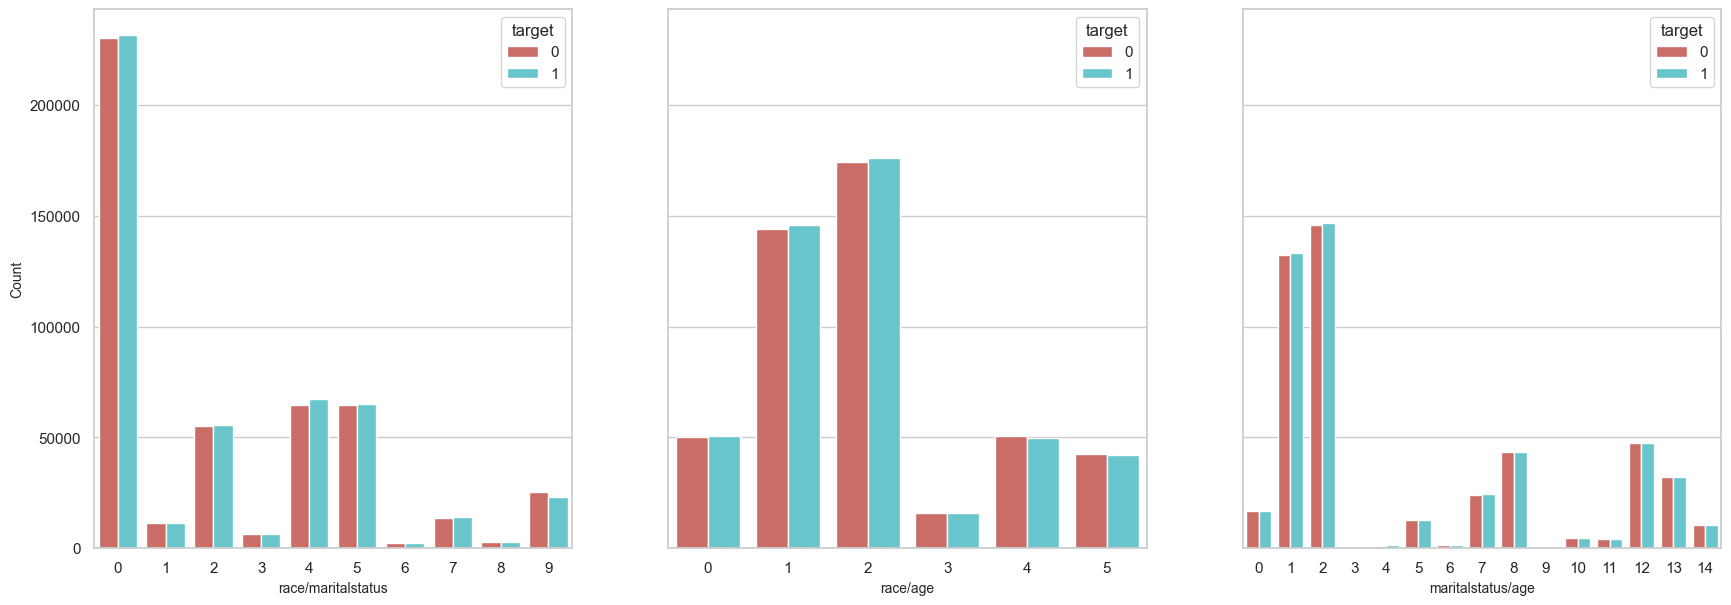

In [214]:
plot_attributes(data_transformed_ps3,protected_attributes_int)

In [18]:
'''
3. Data repairer: Transforms the data distribution so that a given feature distribution is marginally independent of the sensitive attribute, s. 
'''

#transform data
data_to_transform = df_num_int.copy()
columns_to_change = df_num_int.columns.difference(protected_attributes_int).tolist()
columns_to_change.remove(target)
data_transformed_dr1 = pre_process_data_repairer(data_to_transform, "race/age",target,columns_to_change)
data_transformed_dr2 = pre_process_data_repairer(data_transformed_dr1, "race/maritalstatus",target,columns_to_change)
data_transformed_dr3 = pre_process_data_repairer(data_transformed_dr2, "maritalstatus/age",target,columns_to_change)
data_transformed_dr3["race/age"] = data_transformed_dr3["race/age"].astype(int)
data_transformed_dr3["race/maritalstatus"] = data_transformed_dr3["race/maritalstatus"].astype(int)
data_transformed_dr3["maritalstatus/age"] = data_transformed_dr3["maritalstatus/age"].astype(int)

#train
x_test_dr, y_test_dr, y_predicted_dict_dr, metrics_dr_dict = split_and_train(data_transformed_dr3,protected_attributes_int)

#calc metrics
df_test_transformed_dr =calc_fairness_report(x_test_dr, y_test_dr, y_predicted_dict_dr["Catboost"],target,protected_attributes_int)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_dr, protected_attributes_int)


---------- Model name:  DecisionTree ----------

Accuracy score training:
0.7559
Accuracy score test:
0.7549
----------------------------------------

Privileged groups:  [{'race/maritalstatus': 0}]
Unprivileged groups:  [{'race/maritalstatus': 6}, {'race/maritalstatus': 8}, {'race/maritalstatus': 3}, {'race/maritalstatus': 1}, {'race/maritalstatus': 7}, {'race/maritalstatus': 2}, {'race/maritalstatus': 9}, {'race/maritalstatus': 4}, {'race/maritalstatus': 5}]
Disparate Impact Ratio for race/maritalstatus: 0.618
Statistical Parity Difference for race/maritalstatus: -0.259


Privileged groups:  [{'race/age': 2}]
Unprivileged groups:  [{'race/age': 3}, {'race/age': 5}, {'race/age': 4}, {'race/age': 1}, {'race/age': 0}]
Disparate Impact Ratio for race/age: 0.811
Statistical Parity Difference for race/age: -0.116


Privileged groups:  [{'maritalstatus/age': 2}]
Unprivileged groups:  [{'maritalstatus/age': 3}, {'maritalstatus/age': 9}, {'maritalstatus/age': 4}, {'maritalstatus/age': 6}, {'m

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race/maritalstatus,0,0.78,0.88,0.60,0.26,0.21,0.40,0.12,0.74,0.79,0.61,0.70,0.64
1,race/maritalstatus,1,0.70,0.74,0.66,0.30,0.30,0.34,0.26,0.70,0.70,0.02,0.55,0.52
2,race/maritalstatus,2,0.73,0.79,0.64,0.28,0.27,0.36,0.21,0.72,0.73,0.10,0.60,0.55
3,race/maritalstatus,3,0.76,0.68,0.81,0.22,0.28,0.19,0.32,0.78,0.72,0.01,0.39,0.41
4,race/maritalstatus,4,0.82,0.58,0.91,0.16,0.26,0.09,0.42,0.84,0.74,0.10,0.24,0.30
5,race/maritalstatus,5,0.75,0.80,0.70,0.25,0.24,0.30,0.20,0.75,0.76,0.11,0.57,0.54
6,race/maritalstatus,6,0.72,0.63,0.78,0.24,0.35,0.22,0.37,0.76,0.65,0.00,0.38,0.40
7,race/maritalstatus,7,0.71,0.68,0.75,0.28,0.29,0.25,0.32,0.72,0.71,0.02,0.45,0.47
8,race/maritalstatus,8,0.74,0.49,0.88,0.24,0.33,0.12,0.51,0.76,0.67,0.00,0.25,0.35
9,race/maritalstatus,9,0.82,0.52,0.92,0.15,0.29,0.08,0.48,0.85,0.71,0.03,0.19,0.26


Majority class for:  race/maritalstatus  is: 0
Majority class for:  race/age  is: 2
Majority class for:  maritalstatus/age  is: 2
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,race/maritalstatus,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,True,True,True,True,True
1,race/maritalstatus,1,1.46,2.15,1.15,0.86,0.95,0.03,0.78,0.88,...,True,True,True,True,True,True,True,True,True,True
2,race/maritalstatus,2,1.30,1.71,1.09,0.89,0.97,0.17,0.85,0.92,...,False,False,False,False,False,False,False,False,False,False
3,race/maritalstatus,3,1.37,2.62,0.83,0.48,1.06,0.01,0.56,0.90,...,False,True,True,False,True,True,True,False,False,True
4,race/maritalstatus,4,1.26,3.45,0.62,0.22,1.13,0.16,0.33,0.93,...,True,True,True,True,True,True,True,True,True,True
5,race/maritalstatus,5,1.18,1.65,0.97,0.76,1.01,0.18,0.81,0.95,...,True,True,True,True,True,True,True,True,True,True
6,race/maritalstatus,6,1.69,3.09,0.93,0.56,1.03,0.01,0.54,0.82,...,True,True,True,True,True,True,True,True,True,True
7,race/maritalstatus,7,1.42,2.68,1.08,0.63,0.97,0.03,0.64,0.89,...,True,True,True,True,True,True,True,True,True,True
8,race/maritalstatus,8,1.58,4.23,0.91,0.31,1.03,0.00,0.36,0.85,...,True,True,True,True,True,True,True,True,True,True
9,race/maritalstatus,9,1.43,4.01,0.59,0.19,1.14,0.05,0.27,0.89,...,False,True,True,False,True,True,True,False,False,True


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,maritalstatus/age,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,0,binary 0/1,race/age,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,0,binary 0/1,race/maritalstatus,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

In [61]:
'''
In-processing: Fair learn classifier 
'''
def train_with_fairlearn(data, attribute, model, metrics_dict):
    y = data.loc[:, target]
    x = data.drop(target, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
    s_train = x_train[attribute]
    x_train = x_train.drop(columns= [attribute], axis=1)
    s_test = x_test[attribute]
    x_test = x_test.drop(columns= [attribute], axis=1)
    
    fairlearn_clf = FairlearnClassifier(estimator=model, constraint="fairlearn.reductions.DemographicParity",reduction='fairlearn.reductions.ExponentiatedGradient')
    
    fairlearn_clf.fit(x_train, y_train, s_train) 
    y_train_pred = fairlearn_clf.predict_proba(x_train,s_train).astype(int)
    y_test_pred = fairlearn_clf.predict_proba(x_test,s_test).astype(int)
    x_test.insert(len(x_test.columns)-1,attribute,s_test,True) # insert back the attribute
    print("Model:\n", model)
    print(f"Accuracy score training:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Accuracy score test:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Classification report for model: {model} : \n {classification_report(y_test, y_test_pred)}")
    metric  = calc_metrics(x_test=x_test,y_test=y_test,y_predicted=y_test_pred,attributes=[attribute], target=target)
    metrics_dict[model] =metric
    return x_test, y_test, y_test_pred, metrics_dict


data_to_transform = df_num_int.copy()
models = ["sklearn.ensemble.RandomForestClassifier"]
metrics_dict = {}
x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform, "race/age", models[0], metrics_dict)

[INFO] 2024-09-04 10:19:51 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


[INFO] 2024-09-04 10:19:51 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.DemographicParity'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.DemographicParity'>' with parameters: {}.


[INFO] 2024-09-04 10:19:51 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


KeyboardInterrupt: 

In [38]:
#calc metrics
df_test_transformed_fl =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_fl, protected_attributes_int)

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race/maritalstatus,0,0.71,0.69,0.75,0.42,0.17,0.25,0.31,0.58,0.83,0.62,0.53,0.64
1,race/maritalstatus,1,0.66,0.52,0.81,0.39,0.25,0.19,0.48,0.61,0.75,0.02,0.36,0.52
2,race/maritalstatus,2,0.67,0.58,0.78,0.40,0.23,0.22,0.42,0.60,0.77,0.10,0.42,0.55
3,race/maritalstatus,3,0.71,0.50,0.86,0.29,0.28,0.14,0.50,0.71,0.72,0.01,0.29,0.41
4,race/maritalstatus,4,0.80,0.51,0.91,0.18,0.28,0.09,0.49,0.82,0.72,0.12,0.21,0.30
5,race/maritalstatus,5,0.68,0.51,0.89,0.40,0.16,0.11,0.49,0.60,0.84,0.09,0.33,0.54
6,race/maritalstatus,6,0.67,0.24,0.96,0.34,0.21,0.04,0.76,0.66,0.79,0.00,0.12,0.40
7,race/maritalstatus,7,0.64,0.31,0.93,0.40,0.19,0.07,0.69,0.60,0.81,0.01,0.18,0.47
8,race/maritalstatus,8,0.70,0.18,0.98,0.31,0.19,0.02,0.82,0.69,0.81,0.00,0.08,0.35
9,race/maritalstatus,9,0.79,0.35,0.95,0.19,0.31,0.05,0.65,0.81,0.69,0.03,0.13,0.26


Majority class for:  race/maritalstatus  is: 0
Majority class for:  race/age  is: 2
Majority class for:  maritalstatus/age  is: 2
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,race/maritalstatus,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,True,True,True,True,True,True,True,True,True,True
1,race/maritalstatus,1,1.44,1.54,0.92,0.74,1.06,0.03,0.68,0.91,...,True,True,True,True,True,True,True,True,True,True
2,race/maritalstatus,2,1.37,1.35,0.95,0.88,1.04,0.16,0.79,0.92,...,False,False,False,False,False,False,False,False,False,False
3,race/maritalstatus,3,1.64,1.61,0.69,0.55,1.22,0.01,0.55,0.87,...,False,True,True,False,True,True,True,False,False,True
4,race/maritalstatus,4,1.64,1.57,0.44,0.34,1.41,0.20,0.40,0.87,...,False,True,True,False,True,True,True,False,False,True
5,race/maritalstatus,5,0.92,1.59,0.95,0.45,1.04,0.14,0.62,1.02,...,True,True,True,True,True,True,True,True,True,True
6,race/maritalstatus,6,1.22,2.46,0.82,0.17,1.13,0.00,0.23,0.95,...,True,True,True,True,True,True,True,True,True,True
7,race/maritalstatus,7,1.10,2.22,0.95,0.26,1.04,0.02,0.35,0.98,...,True,True,True,True,True,True,True,True,True,True
8,race/maritalstatus,8,1.12,2.65,0.73,0.09,1.19,0.00,0.14,0.98,...,True,True,True,True,True,True,True,True,True,True
9,race/maritalstatus,9,1.80,2.09,0.46,0.22,1.39,0.05,0.25,0.83,...,True,True,True,True,True,True,True,True,True,True


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,maritalstatus/age,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0,binary 0/1,race/age,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,binary 0/1,race/maritalstatus,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

In [58]:
predicts_fairlearn, metrics_fairlearn = post_process_group_threshold_fairlearn(df_num_int, 'race/age', target)

predicts_aequitas = post_process_group_threshold_aequitas(df_num_int, 'race/age', target)

---------- Model name:  DecisionTree ----------

Accuracy score test corrected:
0.7534


In [4]:
metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['race/age']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['race/age']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['race/age']
metrics_rf["Data repairer"] = metrics_dr_dict["RandomForest"]['race/age']
plot_metrics(metrics_rf,'race/age')

NameError: name 'metrics_dict_int' is not defined

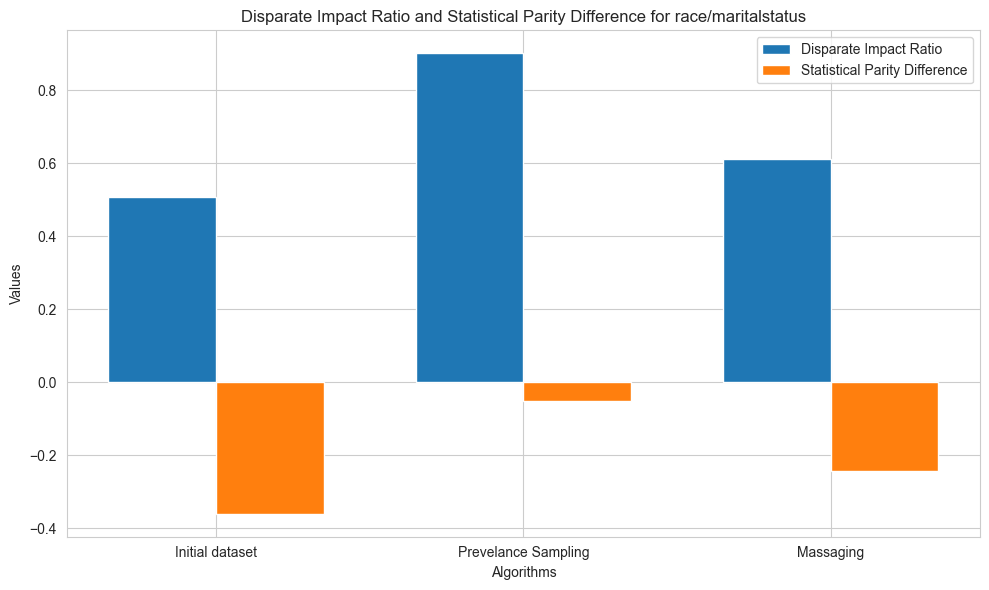

In [122]:
metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['race/maritalstatus']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['race/maritalstatus']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['race/maritalstatus']
plot_metrics(metrics_rf,'race/maritalstatus')

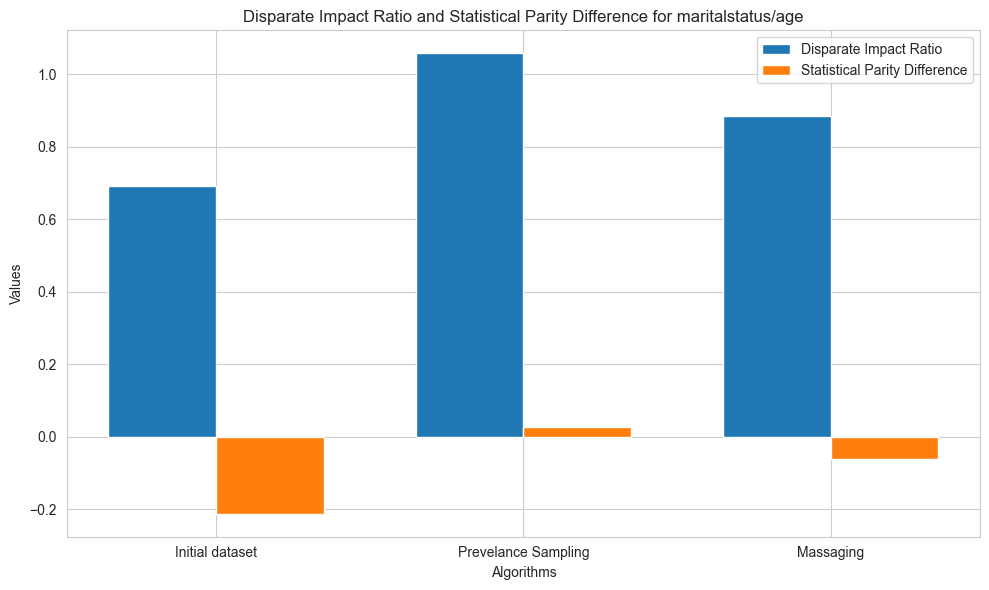

In [123]:
metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['maritalstatus/age']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['maritalstatus/age']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['maritalstatus/age']
plot_metrics(metrics_rf,'maritalstatus/age')

<Figure size 1000x600 with 0 Axes>

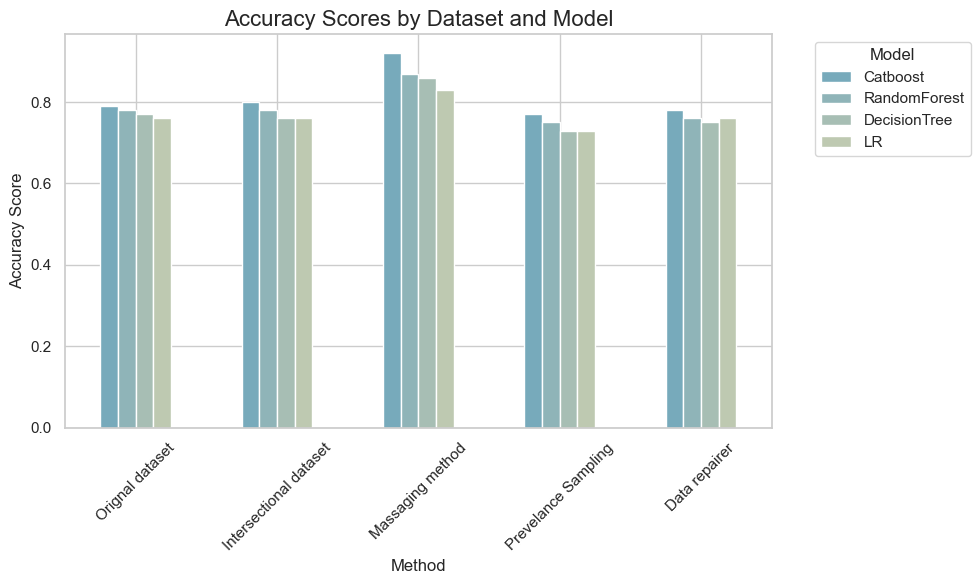

In [191]:

index = 4 
plt.figure(figsize=(10, 6))
accuracy_scores = {}
accuracy_scores["Orignal dataset"] = {"Catboost": 0.79, "RandomForest":0.78, "DecisionTree":0.77, "LR":0.76}
accuracy_scores["Intersectional dataset"] = {"Catboost": 0.8, "RandomForest":0.78, "DecisionTree":0.76, "LR":0.76}
accuracy_scores["Massaging method"] = {"Catboost": 0.92, "RandomForest":0.87, "DecisionTree":0.86, "LR":0.83}
accuracy_scores["Prevelance Sampling"] = {"Catboost": 0.77, "RandomForest":0.75, "DecisionTree":0.73, "LR":0.73}
accuracy_scores["Data repairer"] = {"Catboost": 0.78, "RandomForest":0.76, "DecisionTree":0.75, "LR":0.76}

accuracy_df = pd.DataFrame(accuracy_scores).T
# Set the plot style
sns.set(style="whitegrid")
sns.set_palette("blend:#7AB,#EDA")
# Plot each method's accuracy scores
accuracy_df.plot(kind='bar', figsize=(10, 6))

# Add title and labels
plt.title("Accuracy Scores by Dataset and Model", fontsize=16)
plt.xlabel("Method", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()